In [2]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.thesis.lapse_theory import get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [4]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [5]:
from jobs.theory_lapse.scripts.lapse_fitting import processed_dir, processed_file_name, exp_name, quant_type

n_exp = len(exp_name)
quant = int(''.join(filter(str.isdigit, quant_type)))
temp_surf_lcl_calc = 300            # not actually used in lapse_fitting script - need to re-run using simple lapse fitting

In [6]:
# Load in data
ds = [xr.open_dataset(os.path.join(processed_dir[i], processed_file_name)) for i in range(n_exp)]
co2_vals = [get_co2_multiplier(i) for i in exp_name]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))
ds['rh_REFHT'] = ds['QREFHT'] / sphum_sat(ds.TREFHT, ds.PREFHT)

In [7]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
land_frac_thresh = 0.1
lsm = (land_frac > land_frac_thresh)

In [8]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30]),
                             bottom_labels=True, fontsize=None):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    if fontsize is not None:
        gl.xlabel_style = {'size': fontsize}
        gl.ylabel_style = {'size': fontsize}
    if not bottom_labels:
        gl.bottom_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [9]:
def get_var_av(var, n_lat_av=30, mask=None, av_dim=None):
    """Compute latitude-smoothed mean of a variable, ensuring no NaN latitudes.

    Args:
        var (xr.DataArray): Variable with dimensions ('lat', 'lon', 'sample', ...).
        n_lat_av (int, optional): Number of latitude points for rolling mean. Defaults to 30.
        mask (xr.DataArray, optional): Land-sea mask (True where valid). Defaults to None.

    Returns:
        xr.DataArray: Latitude-smoothed mean with all latitudes filled.
    """
    n_pad = n_lat_av // 2  # half-window size

    # Apply mask if provided
    if mask is not None:
        var = var.where(mask)

    # Take mean over non-lat dims
    if av_dim is None:
        av_dim = [d for d in var.dims if d not in ['lat']]
    var_latmean = var.median(dim=av_dim)

    # Fill NaNs along latitude by nearest interpolation
    var_filled = var_latmean.interpolate_na(dim="lat", method="nearest", fill_value="extrapolate")

    # Pad with edge values to avoid NaNs at the ends
    var_padded = var_filled.pad(lat=(n_pad, n_pad), mode="edge")

    # Apply rolling mean and trim padding
    var_av = var_padded.rolling(lat=n_lat_av, center=True).mean().isel(lat=slice(n_pad, -n_pad))

    return var_av

## Temperature anomaly and change
Figure trying to explain, why hottest days in some regions more in current climate and change with warming differently

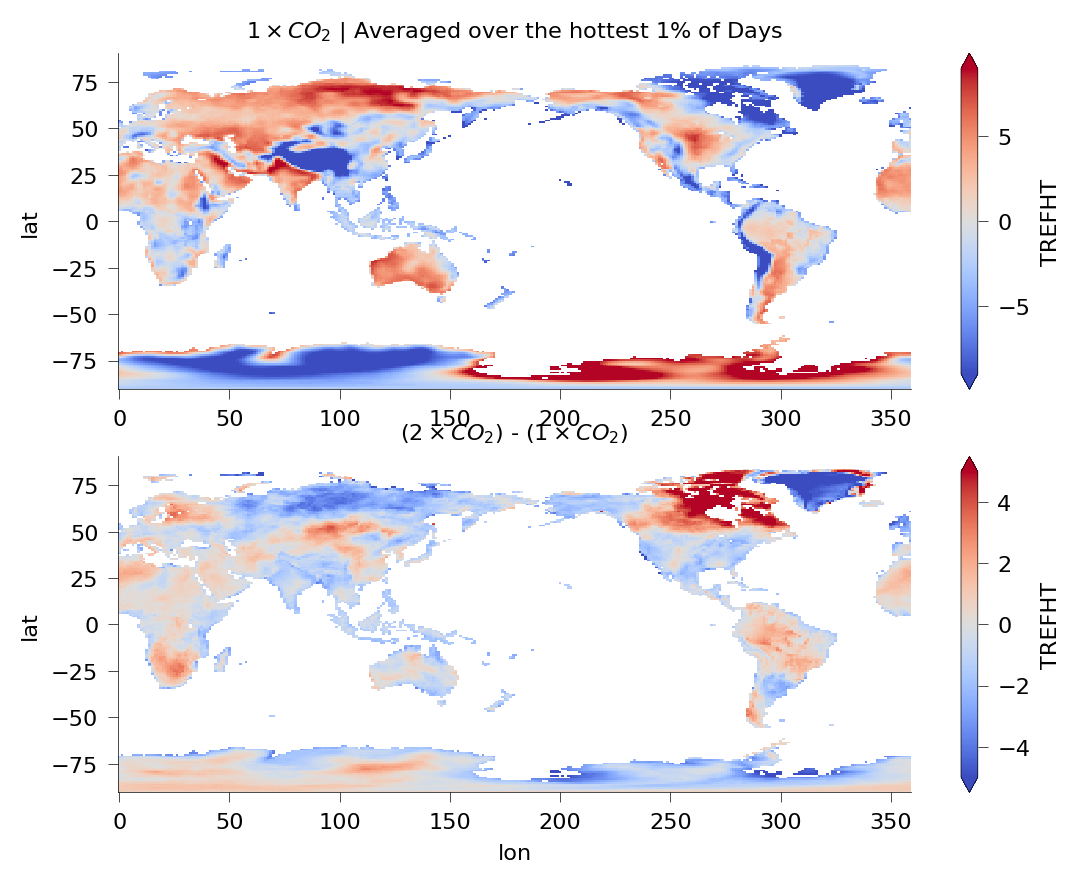

In [10]:
lat_min = -60
lat_max = 80
fig, ax = plt.subplots(2, 1)
# ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})

var = (ds.TREFHT.mean(dim='sample') - get_var_av(ds.TREFHT, mask=lsm, av_dim=['sample', 'lon'])).where(lsm)
# initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, bottom_labels=False, fontsize=10.84)
var.isel(co2=0).plot(ax=ax[0], cmap='coolwarm', vmin=-9)
# im = plot_contour_projection(ax[0], var.isel(co2=0), cmap='coolwarm', levels=np.arange(-9, 10, 2))
# plt.colorbar(im, ax=ax[0], label='$T_s - \overline{T}_s$ [K]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | Averaged over the hottest {100 - quant}% of Days")


# initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
(var.isel(co2=1) - var.isel(co2=0)).plot(ax=ax[1], cmap='coolwarm', vmin=-5)
# plt.colorbar(im, ax=ax[1], label='$\delta (T_s - \overline{T}_s)$ [K]', shrink=0.8)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig, 5)
ax[0].set_xlabel('')
plt.show()
# isca_tools.savefig(fig)

### % of Days convective
Below I plot the number of days for which the convective fitting works well.

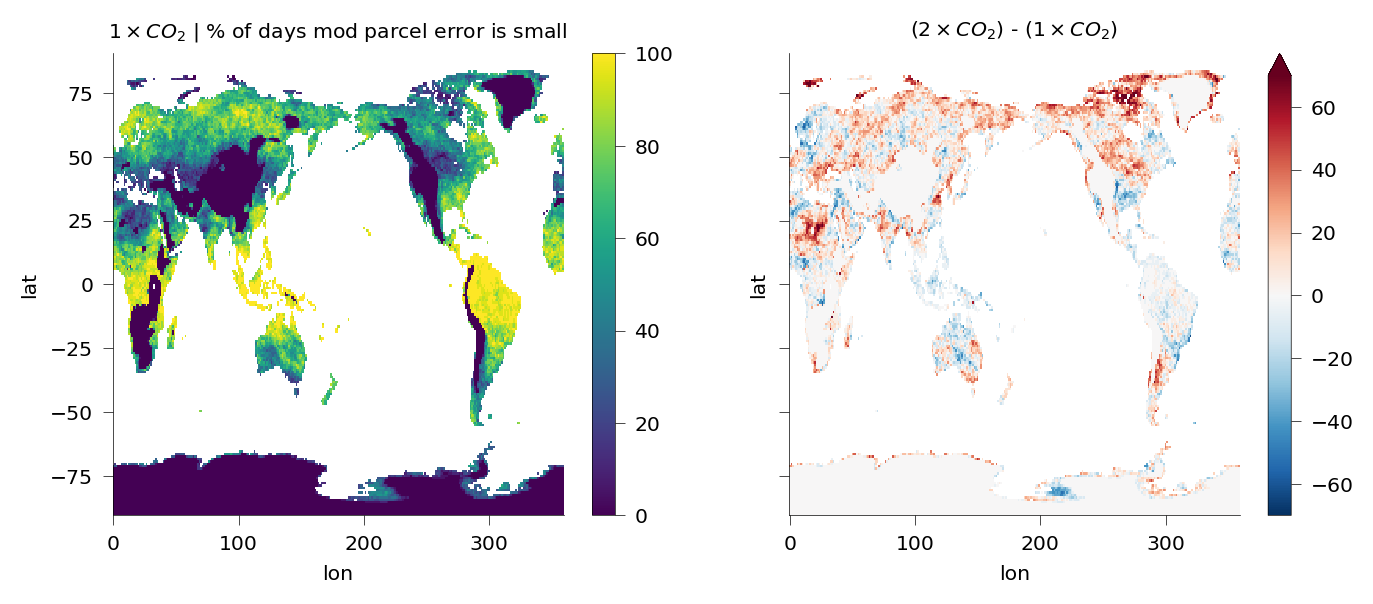

In [107]:
error_thresh = 0.25
error_thresh2 = 0.1
p_thresh = 900*100
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)
mask_use = mask_fit & (ds.PREFHT > p_thresh)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)

var = (100 * mask_use.sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=0).plot(ax=ax[0], vmin=0, vmax=100)
# im = plot_contour_projection(ax[0], var.isel(co2=0), levels=np.arange(0, 120, 20))
# plt.colorbar(im, ax=ax[0], label='Small-error days [%]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | % of days mod parcel error is small")

(var.isel(co2=1) - var.isel(co2=0)).plot(ax=ax[1], vmin=-70)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

### Look at other convective identities
Below, we look at the days which do not have a small `mod_parcel1_error`.


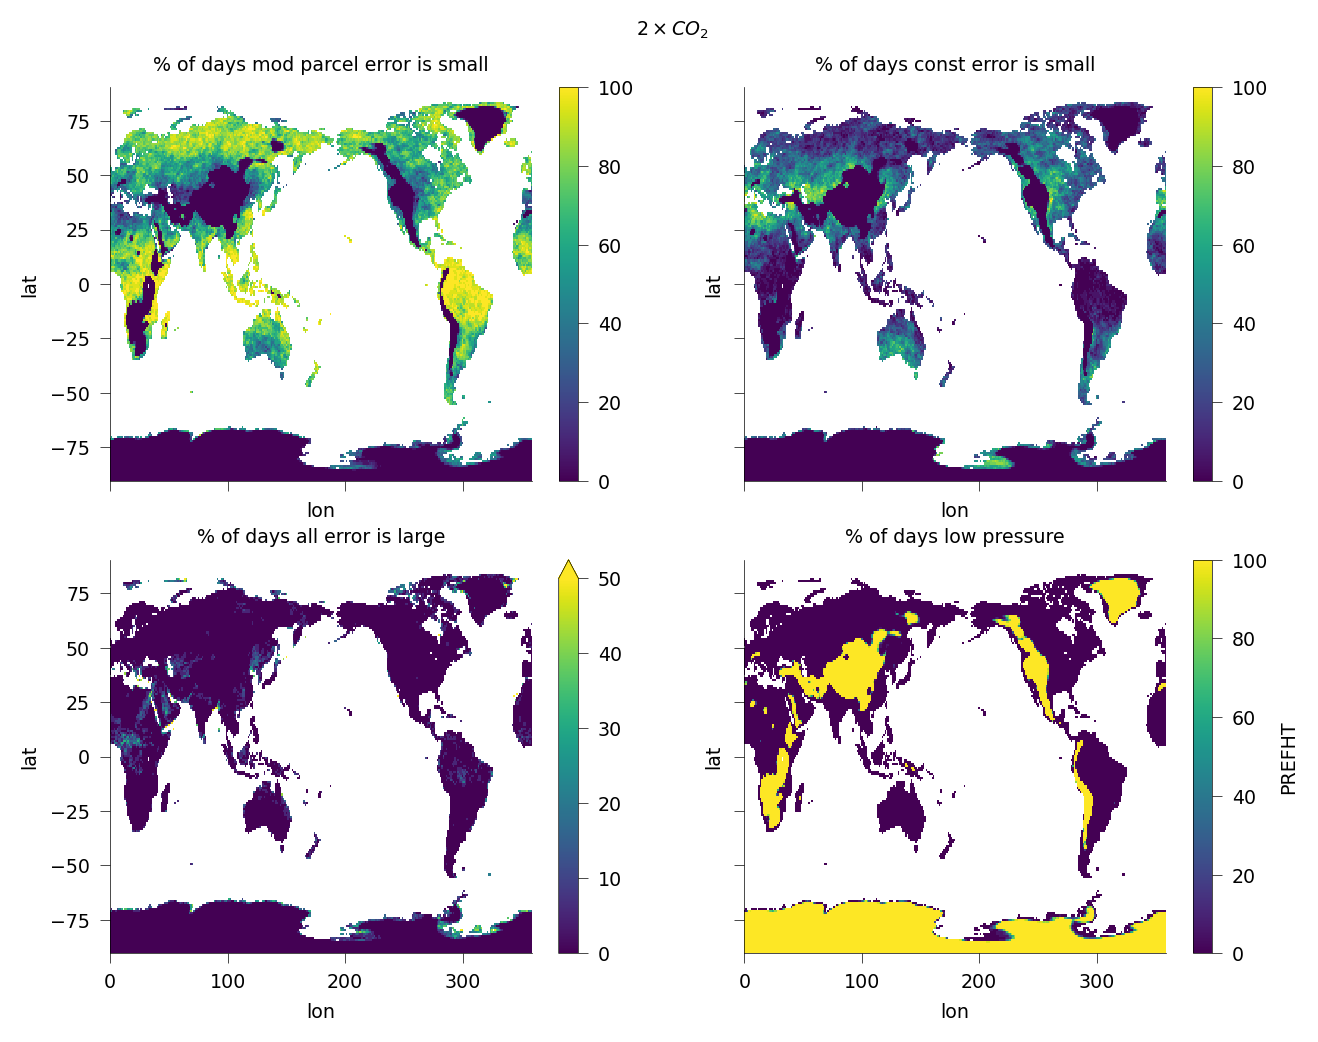

In [92]:
co2_ind_use = 1
p_thresh = 900*100
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
fig_resize(fig, 7.5)

mask_use = mask_fit & (ds.PREFHT > p_thresh)
var = (100 * mask_use.sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=co2_ind_use).plot(ax=ax[0], vmin=0, vmax=100)
ax[0].set_title(f"% of days mod parcel error is small")

mask_use = ~mask_fit & (ds.PREFHT > p_thresh) & (const1_error < error_thresh)
var = (100 * mask_use.sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=co2_ind_use).plot(ax=ax[1], vmin=0, vmax=100)
ax[1].set_title(f"% of days const error is small")

mask_use = ~mask_fit & (ds.PREFHT > p_thresh) & (const1_error > error_thresh)
var = (100 * mask_use.sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=co2_ind_use).plot(ax=ax[2], vmin=0, vmax=50)
ax[2].set_title(f"% of days all error is large")

mask_use = ds.PREFHT <= p_thresh
var = (100 * mask_use.sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=co2_ind_use).plot(ax=ax[3], vmin=0, vmax=100)
ax[3].set_title(f"% of days low pressure")

# initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
# im = plot_contour_projection(ax[1], var.isel(co2=1) - var.isel(co2=0), cmap='coolwarm', levels=np.arange(-40, 60, 20))
# plt.colorbar(im, ax=ax[1], label='Small-error days change [%]', shrink=0.8)
fig.suptitle(f"${int(ds.co2[co2_ind_use])} \\times CO_2$", y=0.94)

fontsize_use = update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

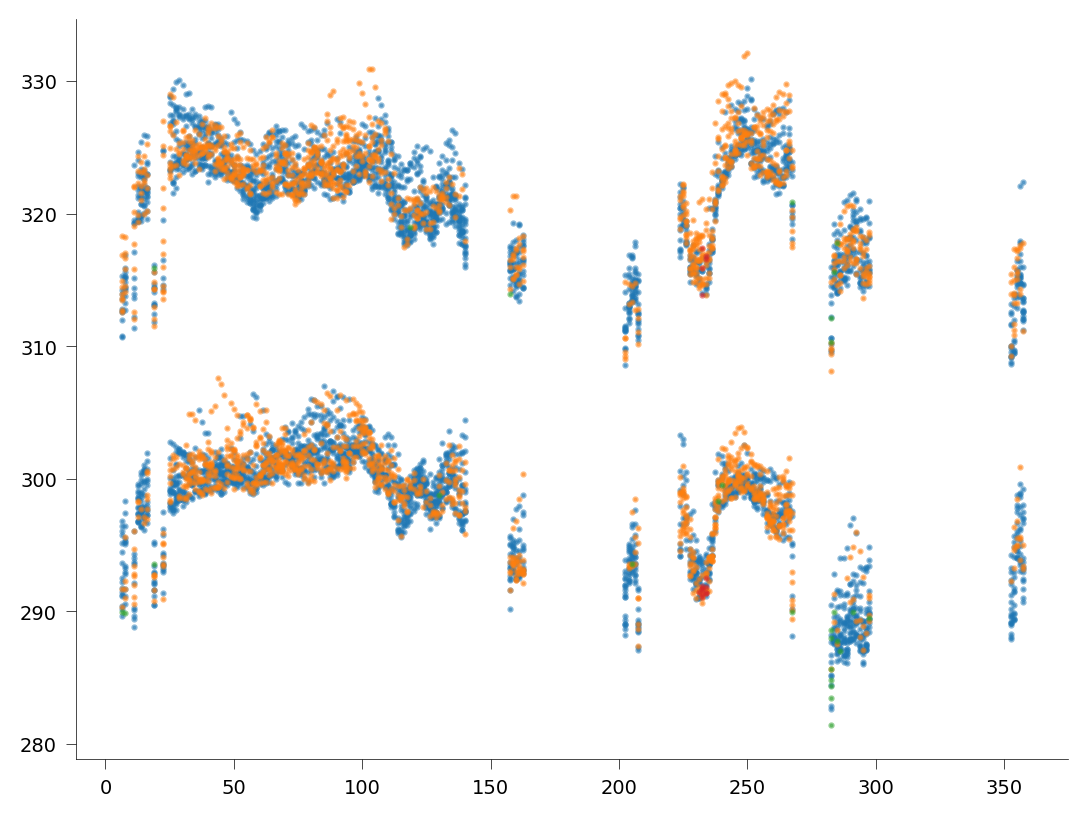

In [175]:
lat_use = 58
for i in range(ds.co2.size):
    mask_use = mask_fit & lsm & (ds.PREFHT > 850*100)
    plt.scatter((ds.PREFHT*0+ds.lon).where(mask_use).sel(lat=lat_use, method='nearest').isel(co2=i),
                ds.TREFHT.where(lsm & (mask_use)).sel(lat=lat_use, method='nearest').isel(co2=i)+15*i, c="C0", marker='.', alpha=0.5)

    mask_use = ~mask_fit & lsm & (ds.PREFHT > 850*100) & (const1_error < error_thresh)
    plt.scatter((ds.PREFHT*0+ds.lon).where(mask_use).sel(lat=lat_use, method='nearest').isel(co2=i),
                ds.TREFHT.where(lsm & (mask_use)).sel(lat=lat_use, method='nearest').isel(co2=i)+15*i, c="C1", marker='.', alpha=0.5)

    mask_use = ~mask_fit & lsm & (ds.PREFHT > 850*100) & (const1_error > error_thresh)
    plt.scatter((ds.PREFHT*0+ds.lon).where(mask_use).sel(lat=lat_use, method='nearest').isel(co2=i),
                ds.TREFHT.where(lsm & (mask_use)).sel(lat=lat_use, method='nearest').isel(co2=i)+15*i, c="C2", marker='.', alpha=0.5)

    mask_use = lsm & (ds.PREFHT < 850*100)
    plt.scatter((ds.PREFHT*0+ds.lon).where(mask_use).sel(lat=lat_use, method='nearest').isel(co2=i),
                ds.TREFHT.where(lsm & (mask_use)).sel(lat=lat_use, method='nearest').isel(co2=i)+15*i, c="C3", marker='.', alpha=0.5)

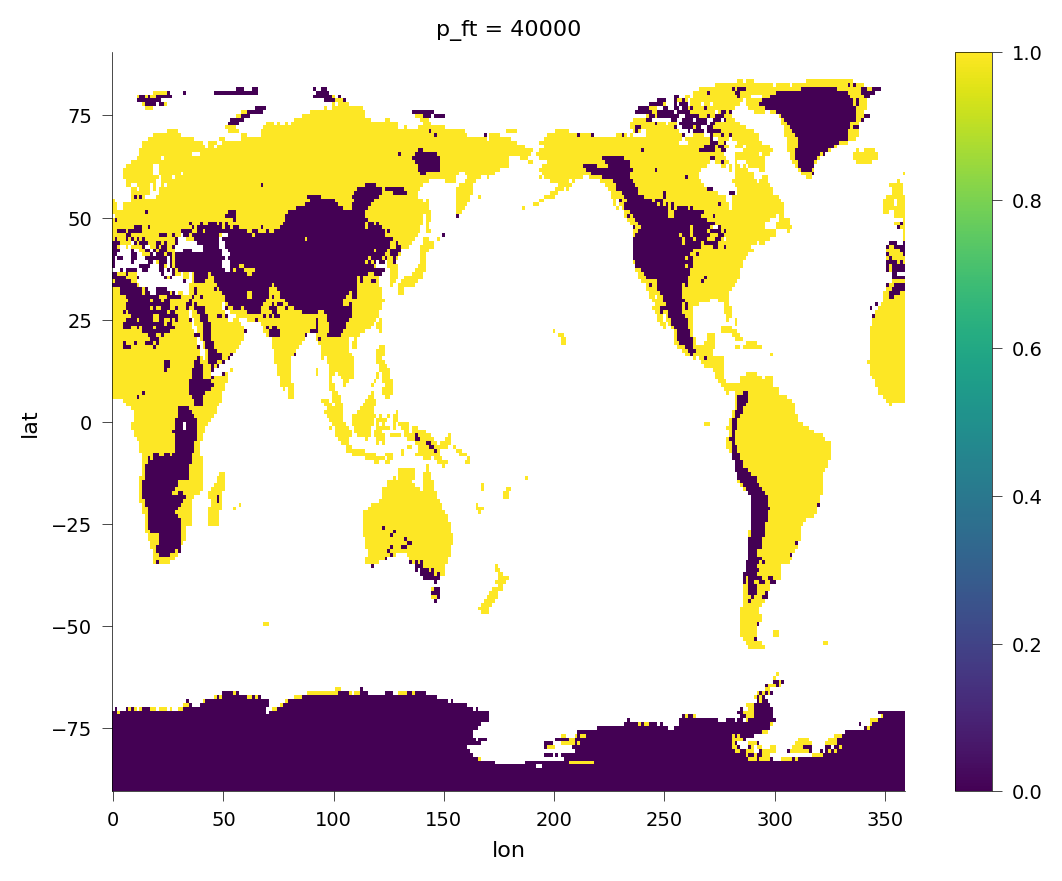

In [129]:
# Atleast 6 days convective in both climates
mask_conv = (mask_fit & (ds.PREFHT > p_thresh)).sum(dim='sample').min(dim='co2')>=0.3*ds.sample.size
mask_conv = mask_conv & lsm
mask_conv_sample = mask_conv & mask_fit
mask_conv.where(lsm).plot()

In [131]:
ds_pca = ds[['PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']]
ds_pca['lapse_mod_D'] = ds_pca.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_pca['lapse_mod_M'] = ds_pca.mod_parcel1_lapse.isel(layer=1) / 1000
ds_pca = ds_pca.drop_vars(['mod_parcel1_lapse'])
ref_method = 'actual'  # Take actual mean values
# ref_method = 'custom'       # Assume follows SQE, and no RH change with warming
if ref_method == 'actual':
    ref_vals = {key: get_var_av(ds_pca[key], mask=mask_conv_sample, av_dim=['sample', 'lon']) for key in ds_pca}
else:
    ref_vals = {key: get_var_av(ds_pca[key].isel(co2=0), mask=mask_conv_sample, av_dim=['sample', 'lon']) for key in
                ['PREFHT', 'rh_REFHT']}
    ref_vals['lapse_mod_D'] = ref_vals['PREFHT'] * 0
    ref_vals['lapse_mod_M'] = ref_vals['PREFHT'] * 0
ref_vals['TREFHT'] = get_var_av(ds.TREFHT, mask=mask_conv_sample, av_dim=['sample', 'lon'])
ds_ref = xr.Dataset(ref_vals)

# Compute ref
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)  # make function work with xarray
ds_ref['T_ft_env'] = get_temp_mod_parcel_xr(ref_vals['rh_REFHT'], ref_vals['PREFHT'], ds.p_ft,
                                            ref_vals['lapse_mod_D'],
                                            ref_vals['lapse_mod_M'], ref_vals['TREFHT'],
                                            temp_surf_lcl_calc=temp_surf_lcl_calc)
for key in ds_pca:
    ds_pca[key] = ds_pca[key] - ds_ref[key]

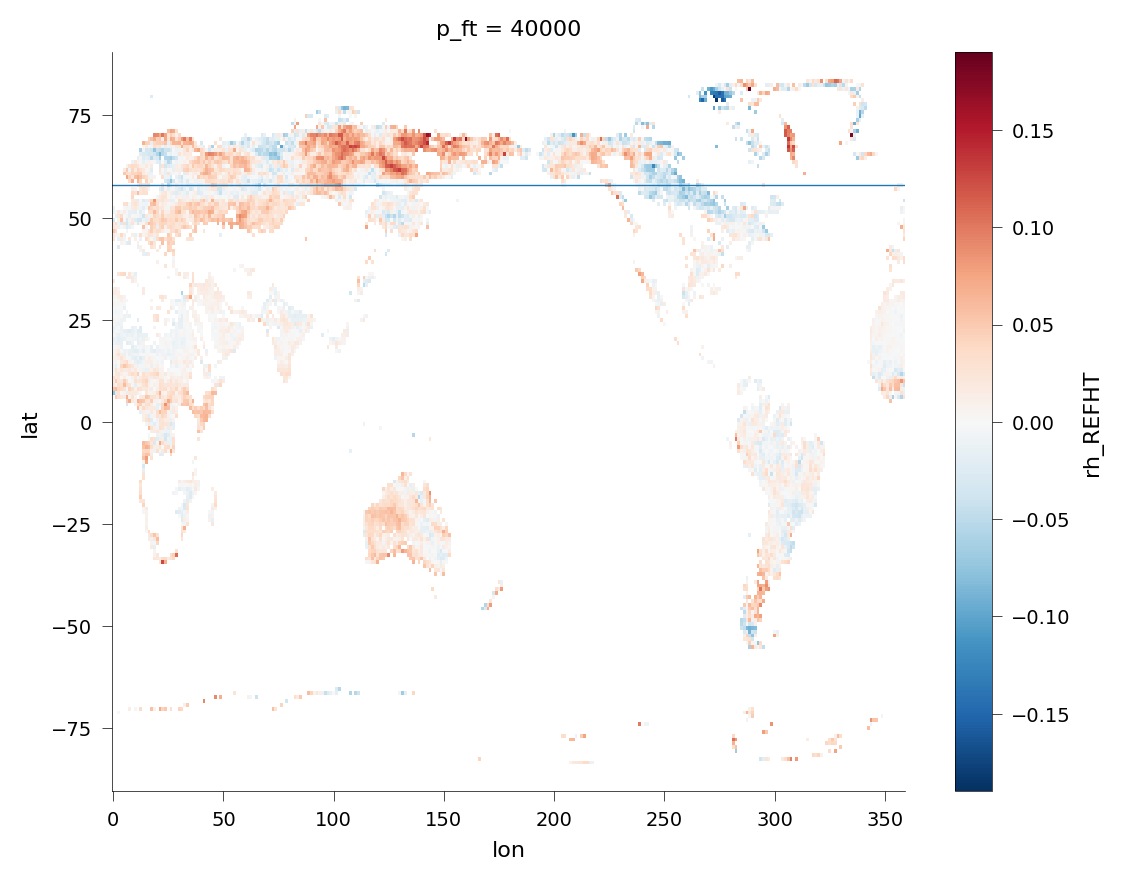

In [198]:
((ds_pca.rh_REFHT).where(mask_conv_sample & (ds_pca.rh_REFHT.isel(co2=1)<0)).isel(co2=1).mean(dim='sample') - \
(ds_pca.rh_REFHT).where(mask_conv_sample & (ds_pca.rh_REFHT.isel(co2=0)<0)).isel(co2=0).mean(dim='sample')).plot()
plt.axhline(58)

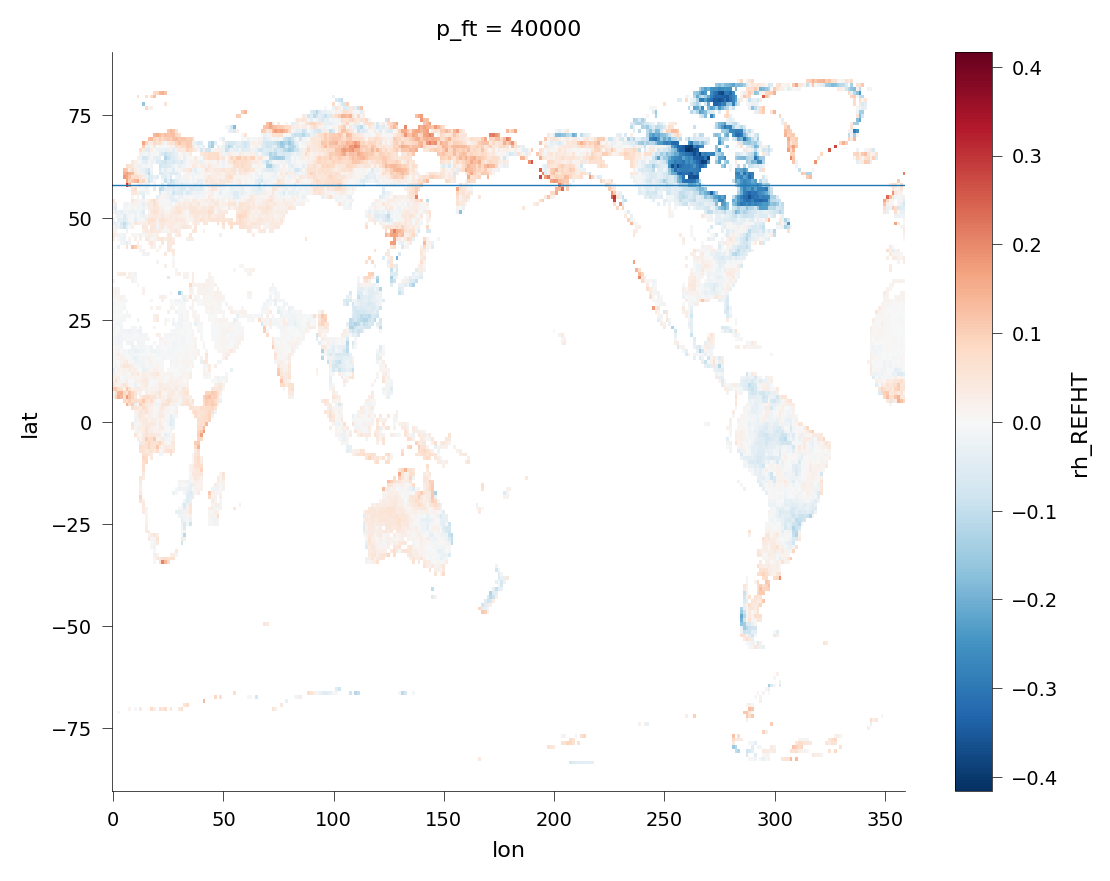

In [186]:
((ds_pca.rh_REFHT).where(mask_conv_sample).isel(co2=1).mean(dim='sample') - \
(ds_pca.rh_REFHT).where(mask_conv_sample).isel(co2=0).mean(dim='sample')).plot()
plt.axhline(58)

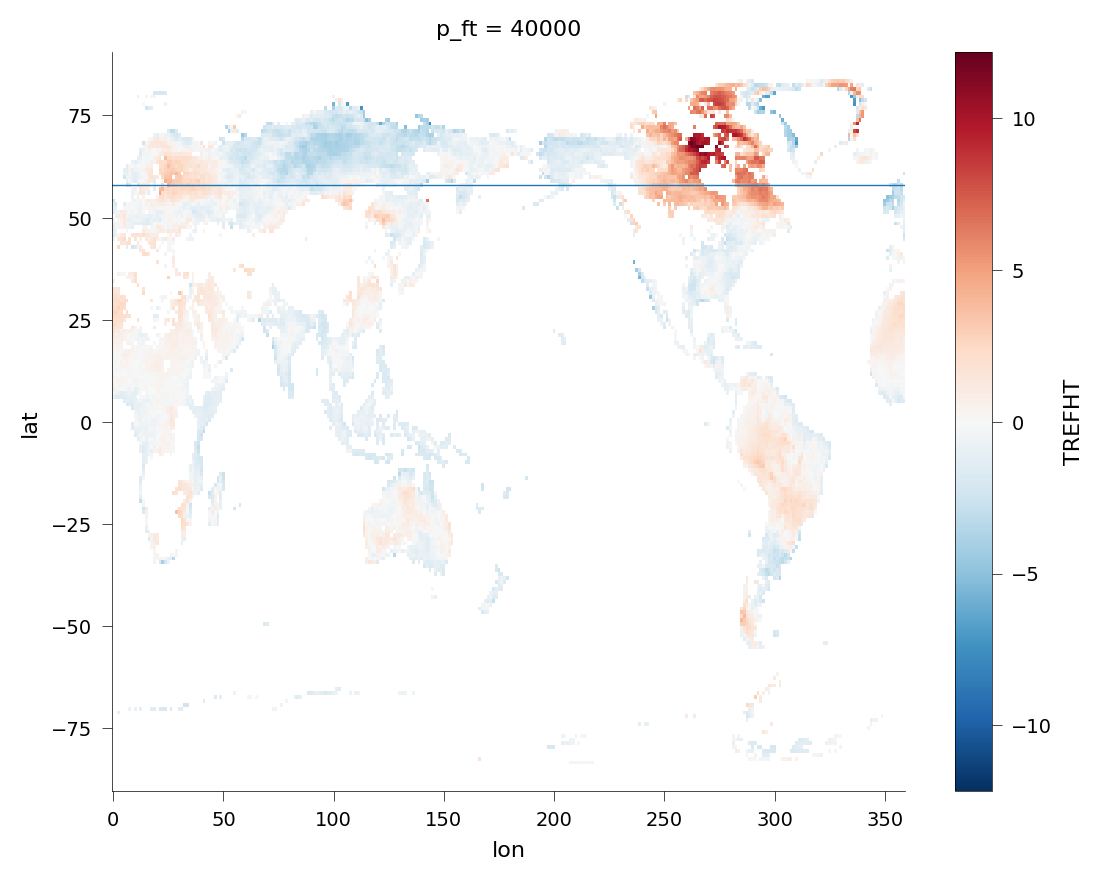

In [166]:
((ds.TREFHT - ds_ref.TREFHT).where(mask_conv_sample).isel(co2=1).mean(dim='sample') - \
(ds.TREFHT - ds_ref.TREFHT).where(mask_conv_sample).isel(co2=0).mean(dim='sample')).plot()
plt.axhline(58)

In [182]:
ds_ref.rh_REFHT.sel(lat=58, method='nearest')

<xarray.DataArray 'rh_REFHT' (co2: 2)> Size: 8B
array([0.3926988 , 0.31898504], dtype=float32)
Coordinates:
    lat      float64 8B 57.96
  * co2      (co2) float64 16B 1.0 2.0
    p_ft     int64 8B 40000

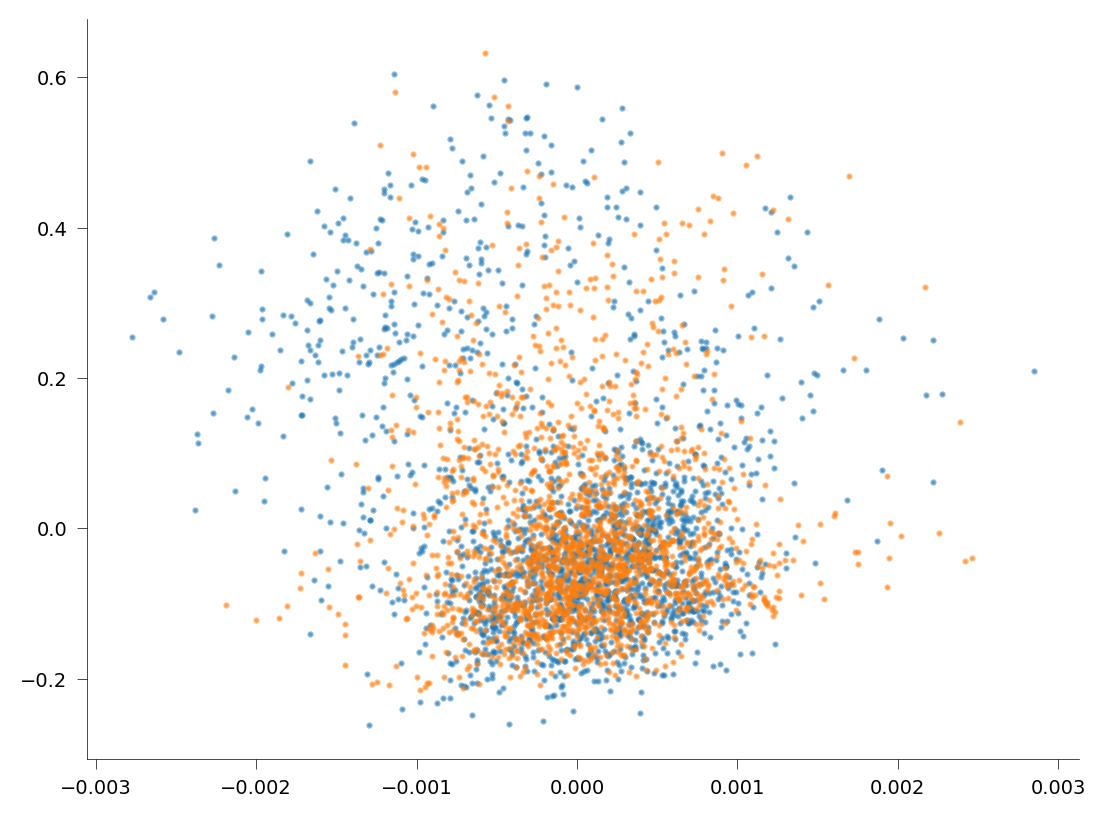

In [185]:
ds_use = ds_pca.where(mask_conv_sample).isel(co2=0).sel(lat=58, method='nearest')
plt.scatter(ds_use.lapse_mod_M, ds_use.rh_REFHT, marker='.', c='C0', alpha=0.5)
ds_use = ds_pca.where(mask_conv_sample).isel(co2=1).sel(lat=58, method='nearest')
plt.scatter(ds_use.lapse_mod_M, ds_use.rh_REFHT, marker='.', c='C1', alpha=0.5)

In [85]:
# Don't include T_ft_zonal decomp in av as does not make much difference - zonal_av looks very like actual temp_ft
mask_use = (lsm & (mask_fit>-1) & (~np.isnan(ds_pca.lapse_mod_D)) & (~np.isnan(ds_pca.lapse_mod_M))).transpose('co2', 'sample', 'lat', 'lon')
pc_output = pca_on_xarray(xr.concat([ds_pca[key] for key in ds_pca if 'zonal' not in key], dim="feature"), n_modes=3,
                          feature_dim_name="feature", valid=mask_use)

In [106]:
def get_temp_surf_from_pc(pc_x_coef, pc_y_coef, pc_eof=pc_output[0], pc_mean=pc_output[2], pc_std=pc_output[3],
                          ds_ref=ds_ref.isel(lat=20, co2=0), pc_x_mode_ind=0, pc_y_mode_ind=2):
    # pc_coef should be n_mode x n_vals
    # pc_eof should be n_mode x n_feature
    # Returns n_pc1_coef x n_pc2_coef
    var = pc_x_coef[:, np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_x_mode_ind).values[np.newaxis, np.newaxis]
    var = var + pc_y_coef[np.newaxis, : np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_y_mode_ind).values[
        np.newaxis, np.newaxis]
    var = var * pc_std.values[np.newaxis, np.newaxis] + pc_mean.values[np.newaxis, np.newaxis]
    # var1 = pc1_coef[:, np.newaxis] * (pc_eof.isel(mode=0) * pc_std).values[np.newaxis]
    # var2 = pc2_coef[:, np.newaxis] * (pc_eof.isel(mode=1) * pc_std).values[np.newaxis]
    # var = var1[:, np.newaxis] + var2[np.newaxis]
    # var = var + pc_mean.values[np.newaxis, np.newaxis]
    p_surf = var[:, :, 0] + float(ds_ref['PREFHT'])
    rh_surf = var[:, :, 1] + float(ds_ref['rh_REFHT'])
    temp_ft_env = var[:, :, 2] + float(ds_ref['T_ft_env'])
    lapse_mod_D = var[:, :, 3] + float(ds_ref['lapse_mod_D'])
    lapse_mod_M = var[:, :, 4] + float(ds_ref['lapse_mod_M'])
    get_temp = np.vectorize(get_temp_mod_parcel)
    return get_temp(rh_surf, p_surf, ds.p_ft, lapse_mod_D, lapse_mod_M, None, temp_ft_env,
                    temp_surf_lcl_calc)

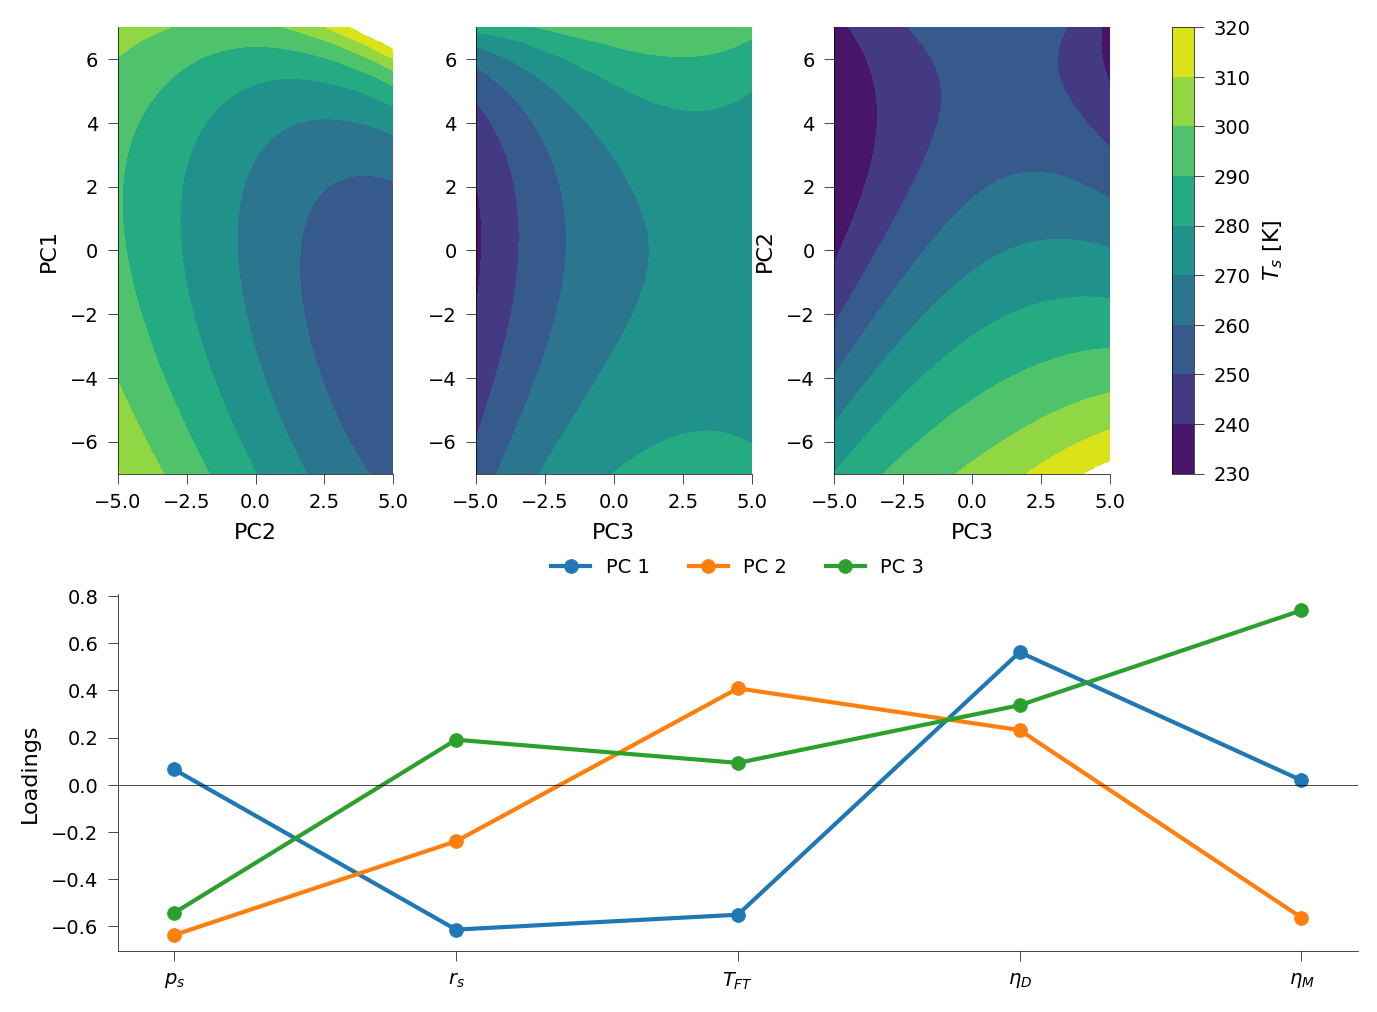

In [131]:
pc_x_coef_plot = np.arange(-5, 5.5, 0.5)
pc_y_coef_plot = np.arange(-7, 7.5, 0.5)

# Generate temperature surfaces
temp_surf_0_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=1, pc_y_mode_ind=0)
temp_surf_2_0 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=0)
temp_surf_2_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=1)

# Use gridspec to span bottom row
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.8], hspace=0.3, wspace=0.3)

# Top row: contour plots
ax0 = fig.add_subplot(gs[0, 0])
fig_resize(fig, 8)
im0 = ax0.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_0_1.T, levels=np.arange(230, 330, 10))
ax0.set_xlabel('PC2')
ax0.set_ylabel('PC1')

ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_0.T, levels=np.arange(230, 330, 10))
ax1.set_xlabel('PC3')

ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_1.T, levels=np.arange(230, 330, 10))
ax2.set_xlabel('PC3')
ax2.set_ylabel('PC2')

# Colorbar for top row
plt.colorbar(im2, ax=[ax0, ax1, ax2], label='$T_s$ [K]')

# Bottom row: single axis spanning all columns
ax_line = fig.add_subplot(gs[1, :])
for mode in range(pc_output[0].mode.size):
    ax_line.plot(np.arange(5), pc_output[0].isel(mode=mode), label=f'PC {mode + 1}', color=f"C{mode}", marker='o',
                 lw=1.5, markersize=5)
ax_line.set_xticks(np.arange(pc_output[0].feature.size))
ax_line.set_xticklabels(['$p_s$', '$r_s$', '$T_{FT}$', '$\eta_D$', '$\eta_M$'])
ax_line.set_ylabel('Loadings')
ax_line.legend(ncol=3, bbox_to_anchor=(0.5, 1.00), loc='lower center')
ax_line.axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [133]:
def get_temp_surf_from_pc_xr(pc_coef, pc_eof, ds_ref, pc_mean=pc_output[2], pc_std=pc_output[3],
                             p_ft=ds.p_ft, temp_surf_lcl_calc=temp_surf_lcl_calc,
                             var_manual=None):
    var = (pc_coef * pc_eof).sum(dim='mode')
    var = var * pc_std + pc_mean

    var_dict = {}
    for i, key in enumerate(['PREFHT', 'rh_REFHT', 'T_ft_env', 'lapse_mod_D', 'lapse_mod_M']):
        var_dict[key] = var.isel(feature=i) + ds_ref[f"{key}_ref"]
    if var_manual:
        for key in var_manual:
            var_dict[key] = var_manual[key]
    return get_temp_mod_parcel_xr(var_dict['rh_REFHT'], var_dict['PREFHT'], p_ft, var_dict['lapse_mod_D'],
                                  var_dict['lapse_mod_M'],
                                  None, var_dict['T_ft_env'], temp_surf_lcl_calc)

In [255]:
ds_sl = ds.sel(lat=65, method='nearest')
# ds_quant_sl = ds_quant.isel(lat=0, surf=0)
# ds_quant_sl['cluster_ind'] = cluster_ind.sel(lat=ds_quant_sl['lat'])
ds_sl['pc_coef'] = pc_output[1].sel(lat=ds_sl['lat'])
for key in ds_pca:
    ds_sl[key] = ds_pca[key].sel(lat=ds_sl['lat'])
for key in ds_ref:
    ds_sl[f"{key}_ref"] = ds_ref[key].sel(lat=ds_sl['lat'])

In [256]:
TREFHT_recon = {}
var_recon_list = ['PREFHT', 'rh_REFHT', 'T_ft_env', 'lapse_mod_D', 'lapse_mod_M']
with tqdm(total=len(var_recon_list) + 3, position=0, leave=True) as pbar:
    for i in range(3):
        TREFHT_recon[f'PC{i + 1}'] = get_temp_surf_from_pc_xr(ds_sl.pc_coef.sel(mode=slice(0, i)),
                                                              pc_output[0].sel(mode=slice(0, i)), ds_sl)
        pbar.update(1)
    for i, key in enumerate(var_recon_list):
        # TREFHT_recon[key] = get_temp_surf_from_pc_xr(ds_quant_sl.pc_coef.sel(mode=slice(0, 0)),
        #                                              pc_output[0].sel(mode=slice(0, 0)), ds_quant_sl,
        #                                              var_manual={key: ds_quant_sl[key] + ds_quant_sl[f"{key}_ref"]})
        # pbar.update(1)
        TREFHT_recon[key + '_noPC'] = get_temp_surf_from_pc_xr(ds_sl.pc_coef.sel(mode=slice(0, 0)) * 0,
                                                               pc_output[0].sel(mode=slice(0, 0)), ds_sl,
                                                               var_manual={
                                                                   key: ds_sl[key] + ds_sl[f"{key}_ref"]})
        pbar.update(1)
TREFHT_recon = xr.Dataset(TREFHT_recon)

  0%|          | 0/8 [00:00<?, ?it/s]

In [257]:
def select_closest_feature(data: xr.DataArray, target: xr.DataArray, min_dim='feature'):
    diff = abs(data - target)
    idx = diff.argmin(dim=min_dim)
    return data.isel(feature=idx), idx


# TREFHT_recon['best'], TREFHT_recon['cluster_idx'] = \
#     select_closest_feature(xr.concat(list(TREFHT_recon[var_recon_list].values()), dim="feature"), ds_quant_sl.TREFHT)

TREFHT_recon['best_noPC'], TREFHT_recon['cluster_idx_noPC'] = \
    select_closest_feature(
        xr.concat(list(TREFHT_recon[[f"{key}_noPC" for key in var_recon_list]].values()), dim="feature"),
        ds_sl.TREFHT)
# Just assume ref values for each day - idea of worst possible approximation
TREFHT_recon['ref'] = get_temp_surf_from_pc_xr(ds_sl.pc_coef.sel(mode=slice(0, 0)).isel(sample=0) * 0,
                                               pc_output[0].sel(mode=slice(0, 0)), ds_sl)

# Sanity check that this matches exactly
TREFHT_recon['exact'] = get_temp_surf_from_pc_xr(ds_sl.pc_coef.sel(mode=slice(0, 0)),
                                                 pc_output[0].sel(mode=slice(0, 0)), ds_sl,
                                                 var_manual={
                                                     key: ds_sl[key] + ds_sl[f"{key}_ref"] for key in var_recon_list})

In [258]:
with tqdm(total=int(len(var_recon_list)*(len(var_recon_list)-1)/2), position=0, leave=True) as pbar:
    for i, key in enumerate(var_recon_list):
        for j, key2 in enumerate(var_recon_list):
            if j >= i:
                continue
            TREFHT_recon[key + '_' + key2 + '_nl'] = get_temp_surf_from_pc_xr(
                ds_sl.pc_coef.sel(mode=slice(0, 0)) * 0,
                pc_output[0].sel(mode=slice(0, 0)), ds_sl,
                var_manual={
                    key: ds_sl[key] + ds_sl[f"{key}_ref"],
                    key2: ds_sl[key2] + ds_sl[f"{key2}_ref"]})
            pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [259]:
if 'best_nl' in TREFHT_recon:
    TREFHT_recon = TREFHT_recon.drop('best_nl')
if 'cluster_idx_nl' in TREFHT_recon:
    TREFHT_recon = TREFHT_recon.drop('cluster_idx_nl')
TREFHT_recon['best_nl'], TREFHT_recon['cluster_idx_nl'] = \
    select_closest_feature(
        xr.concat(list(TREFHT_recon[[key for key in TREFHT_recon if 'nl' in key]].values()), dim="feature"),
        ds_sl.TREFHT)

# If second variable does not help much, then set to single variable method
temp_diff_thresh = 0.3
temp_diff_thresh = -20    # so force a 2nd variable for each point
change_cond = np.abs(TREFHT_recon['best_nl'] - TREFHT_recon['best_noPC']) > temp_diff_thresh
TREFHT_recon['best_nl'] = TREFHT_recon['best_nl'].where(change_cond, TREFHT_recon['best_noPC'])
TREFHT_recon['cluster_idx_nl'] = TREFHT_recon['cluster_idx_nl'].where(change_cond,
                                                                      -TREFHT_recon['cluster_idx_noPC'] - 1)

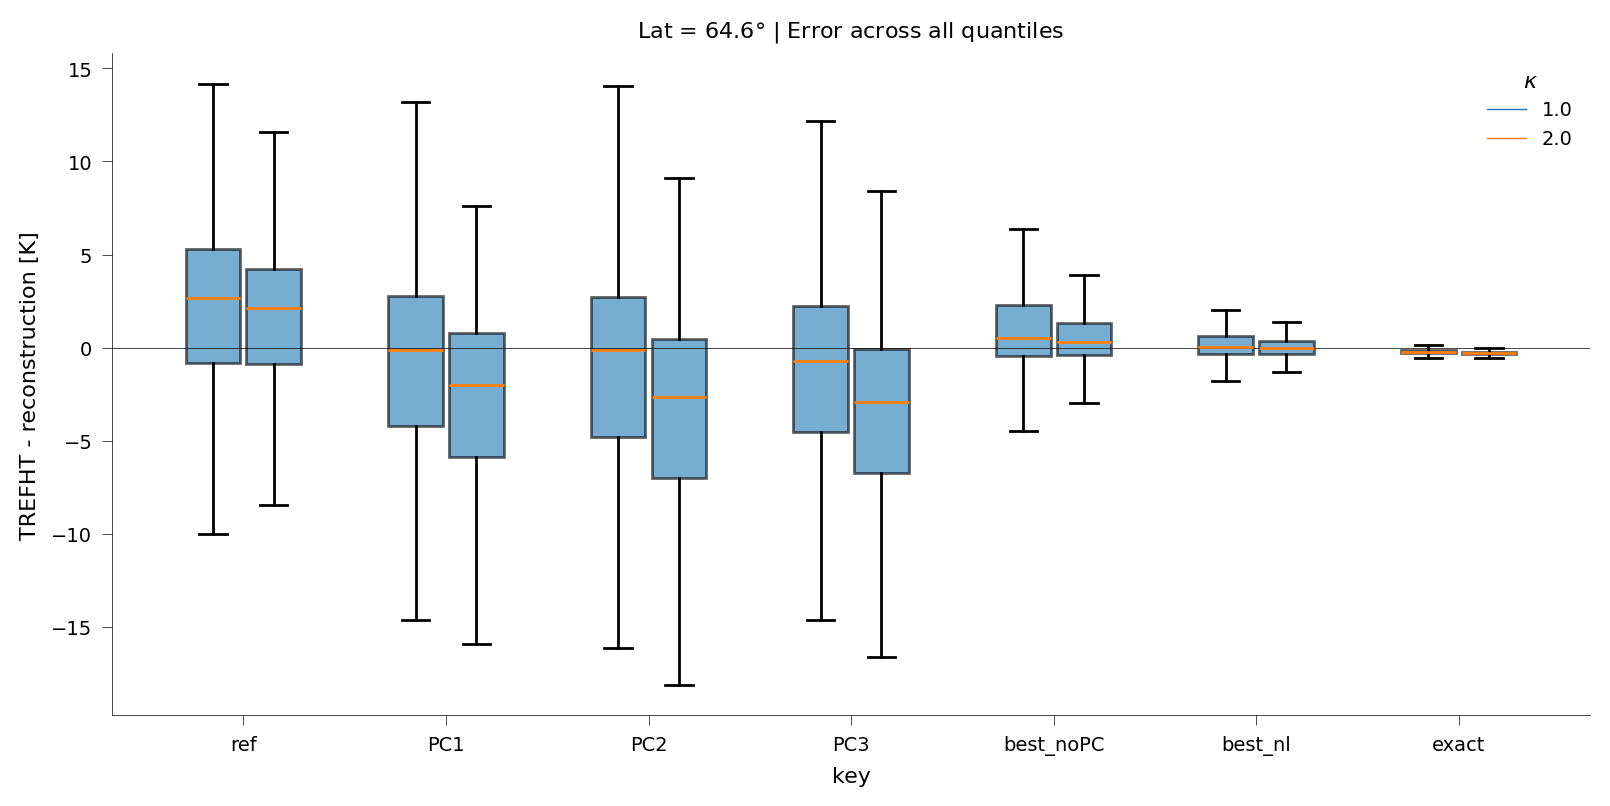

In [260]:
import matplotlib.pyplot as plt
import numpy as np

keys = ['ref', 'PC1', 'PC2', 'PC3', 'best_noPC', 'best_nl', 'exact']
tau_vals = ds_sl.co2.values
n_keys = len(keys)
n_tau = len(tau_vals)

# Collect data in a 2D list: data[key][tau]
all_data = []
for key in keys:
    key_data = []
    for i in range(n_tau):
        mask_i = lsm.sel(lat=ds_sl['lat'])
        arr = (ds_sl.TREFHT - TREFHT_recon[key]).isel(co2=i)
        mask_i = arr*0 + mask_i
        arr = arr.values.flatten()[mask_i.values.flatten()>0]
        key_data.append(arr)
    all_data.append(key_data)

# Plot
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 8, ar=2)
group_width = 0.6
box_width = group_width / n_tau
x_base = np.arange(n_keys)

for j in range(n_tau):
    positions = x_base - group_width / 2 + j * box_width + box_width / 2
    ax.boxplot(
        [all_data[i][j] for i in range(n_keys)],
        positions=positions,
        widths=box_width * 0.9,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(alpha=0.6)
    )

# X labels
ax.set_xticks(x_base)
ax.set_xticklabels(keys)

ax.set_xlabel("key")
ax.set_ylabel("TREFHT - reconstruction [K]")
ax.set_title(f"Lat = {ds_sl.lat:.1f}$\degree$ | Error across all quantiles")

# Legend
legend_labels = [f"{v:.1f}" for v in tau_vals]
for j in range(n_tau):
    ax.plot([], [], label=legend_labels[j])
ax.legend(title="$\kappa$")
ax.axhline(0, color="k", lw=ax_linewidth)

plt.tight_layout()
plt.show()

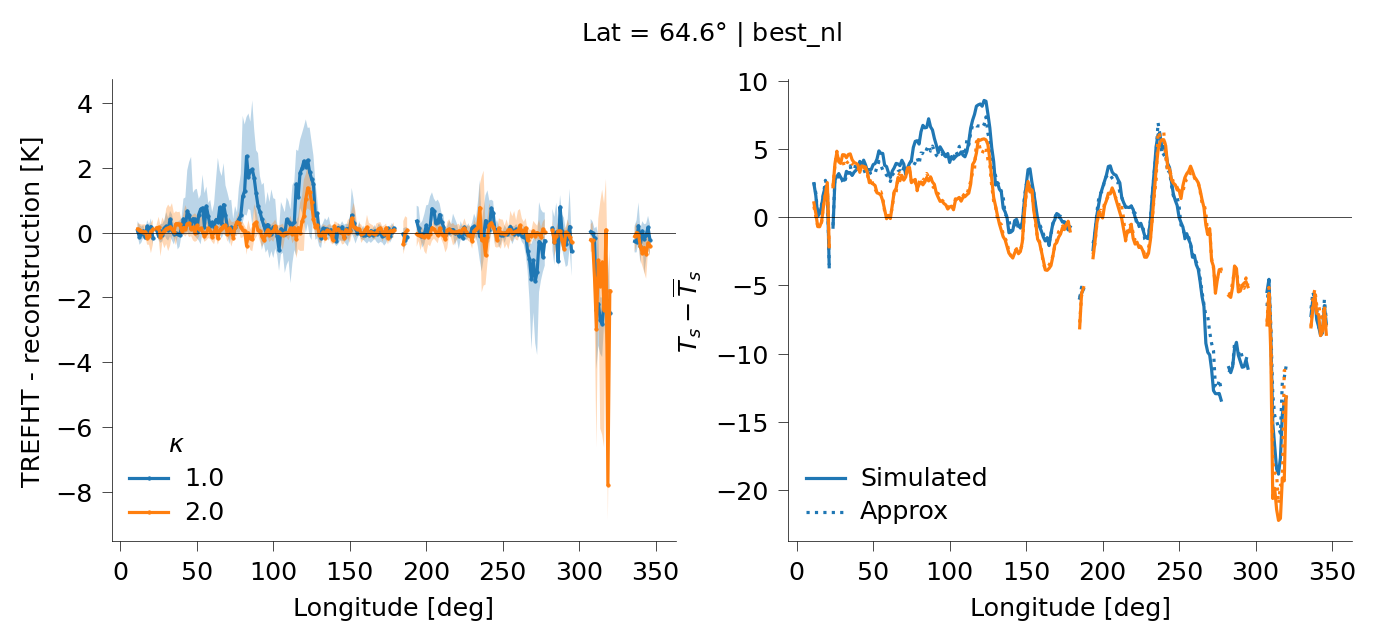

In [262]:
key = 'best_nl'
shift_quant = 0
fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, 8)
for i in range(n_tau):
    var = (ds_sl.TREFHT - TREFHT_recon[key]).isel(co2=i)
    mask_i = lsm.sel(lat=ds_sl['lat'])
    ax[0].plot(ds_sl.lon.where(mask_i), var.quantile(0.5, dim='sample').where(mask_i), marker='.', label=f"{ds_sl.co2.values[i]:.1f}")
    ax[0].fill_between(ds_sl.lon.where(mask_i), var.quantile(0.25, dim='sample').where(mask_i), var.quantile(0.75, dim='sample').where(mask_i),
                       alpha=0.3)
    ax[1].plot(ds_sl.lon.where(mask_i), (ds_sl.TREFHT-ds_sl.TREFHT_ref).quantile(0.5, dim='sample').isel(co2=i).where(mask_i),
               label='Simulated' if i==0 else None)
    ax[1].plot(ds_sl.lon.where(mask_i), (TREFHT_recon[key]-ds_sl.TREFHT_ref).quantile(0.5, dim='sample').isel(co2=i).where(mask_i),
               linestyle=':', color=f"C{i}", label='Approx' if i==0 else None)
ax[0].set_xlabel('Longitude [deg]')
ax[1].set_xlabel('Longitude [deg]')
ax[0].set_ylabel("TREFHT - reconstruction [K]")
fig.suptitle(f"Lat = {ds_sl.lat:.1f}$\degree$ | {key}")
if shift_quant != 0:
    ax[1].set_title(f"$\kappa = {ds_sl.tau_lw.values[0]:.1f}$ shifted in $x$ by -{shift_quant}")
update_linewidth(fig)
ax[0].axhline(0, color="k", lw=ax_linewidth)
ax[1].axhline(0, color="k", lw=ax_linewidth)
ax[0].legend(title='$\kappa$')
ax[1].legend()
ax[1].set_ylabel("$T_s - \overline{T}_s$")
update_fontsize(fig)
plt.show()

In [263]:
k = 0
ds_use = {'var1_id': TREFHT_recon['cluster_idx_nl']*0,
          'var2_id': TREFHT_recon['cluster_idx_nl']*0,
          'TREFHT_cont1': TREFHT_recon['best_nl']*1,
          'TREFHT_cont2': TREFHT_recon['best_nl']*1}
for i, key in enumerate(var_recon_list):
    for j, key2 in enumerate(var_recon_list):
        if j >= i:
            continue
        use_ind = TREFHT_recon['cluster_idx_nl'] == k
        ds_use['var1_id'] = ds_use['var1_id'].where(~use_ind, i)
        ds_use['var2_id'] = ds_use['var2_id'].where(~use_ind, j)
        ds_use['TREFHT_cont1'] = ds_use['TREFHT_cont1'].where(~use_ind, TREFHT_recon['best_nl']-TREFHT_recon[f'{key2}_noPC'])
        ds_use['TREFHT_cont2'] = ds_use['TREFHT_cont2'].where(~use_ind, TREFHT_recon['best_nl']-TREFHT_recon[f'{key}_noPC'])
        k+=1
ds_use = xr.Dataset(ds_use).where(lsm.sel(lat=ds_sl.lat))           # only keep land coordinates

### $T_s$ Contribution Space
Above, we saw that the temperature anomaly can be well explained by just two variables. Below we plot the distribution of points in the space of these two variables. There is a clear change in the shape going to the warmer simulation.

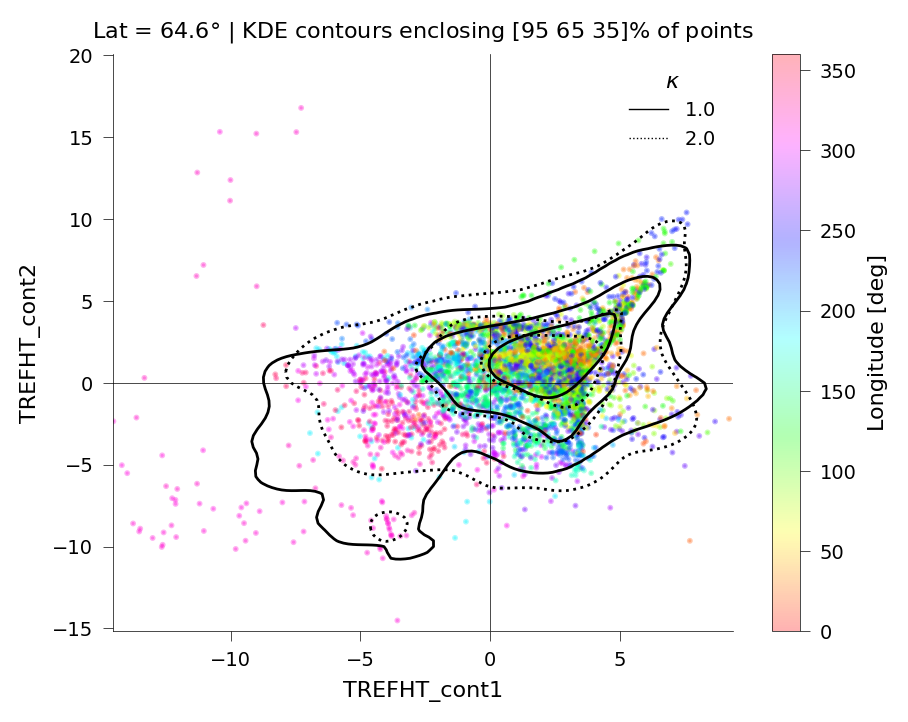

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

scatter_co2_ind_show = 1

# Define cumulative probabilities for contours
cum_levels = np.arange(0.35, 1.0, 0.3)[::-1]  # 90%, 80%, ..., 10%

# Grid for evaluation
x_min = ds_use['TREFHT_cont1'].min().item()
x_max = ds_use['TREFHT_cont1'].max().item()
y_min = ds_use['TREFHT_cont2'].min().item()
y_max = ds_use['TREFHT_cont2'].max().item()
X, Y = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
positions = np.vstack([X.ravel(), Y.ravel()])

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)
ax_lim_cont = [[0, 0] for i in range(2)]
for i in range(ds.co2.size):
    x = ds_use['TREFHT_cont1'].isel(co2=i).values.flatten()
    y = ds_use['TREFHT_cont2'].isel(co2=i).values.flatten()
    values = np.vstack([x[np.isfinite(x)], y[np.isfinite(x)]])

    for j in range(2):
        if np.nanquantile(values[j], 0.005) < ax_lim_cont[j][0]:
            ax_lim_cont[j][0] = np.nanquantile(values[j], 0.005)
        if np.nanquantile(values[j], 0.999) > ax_lim_cont[j][1]:
            ax_lim_cont[j][1] = np.nanquantile(values[j], 0.999)

    # KDE estimate
    kde = gaussian_kde(values)
    Z = kde(positions).reshape(X.shape)

    # Compute contour levels that enclose desired fraction of points
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]  # sort descending
    cumsum = np.cumsum(Z_sorted)
    cumsum /= cumsum[-1]  # normalize to 1

    # Map cumulative probability to density thresholds
    levels = [Z_sorted[np.searchsorted(cumsum, lev)] for lev in cum_levels]

    # Plot contours
    cs = ax.contour(X, Y, Z, levels=levels, colors='k', linewidths=1, linestyles=[None, ':'][i])
    # Below line is for legend label
    ax.plot(0, 0, color='k', linestyle=[None, ':'][i], label=f"${ds_sl.co2.values[i]:.1f}$")
    if i == scatter_co2_ind_show:
        x = (ds_use['TREFHT_cont1']).isel(co2=i)
        y = (ds_use['TREFHT_cont2']).isel(co2=i)
        im = ax.scatter(x, y, c=(x*0+ds_use.lon) % 360, marker='.', s=5, alpha=0.3, cmap='hsv', vmin=0, vmax=360)
plt.colorbar(im, ax=ax, label='Longitude [deg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.legend(title='$\kappa$')
ax.set_xlabel("TREFHT_cont1")
ax.set_ylabel("TREFHT_cont2")
ax.set_xlim(ax_lim_cont[0])
ax.set_ylim(ax_lim_cont[1])
ax.set_title(f"Lat = {ds_sl.lat:.1f}$\degree$ | KDE contours enclosing {(np.round(cum_levels*100)).astype(int)}% of points")
plt.show()

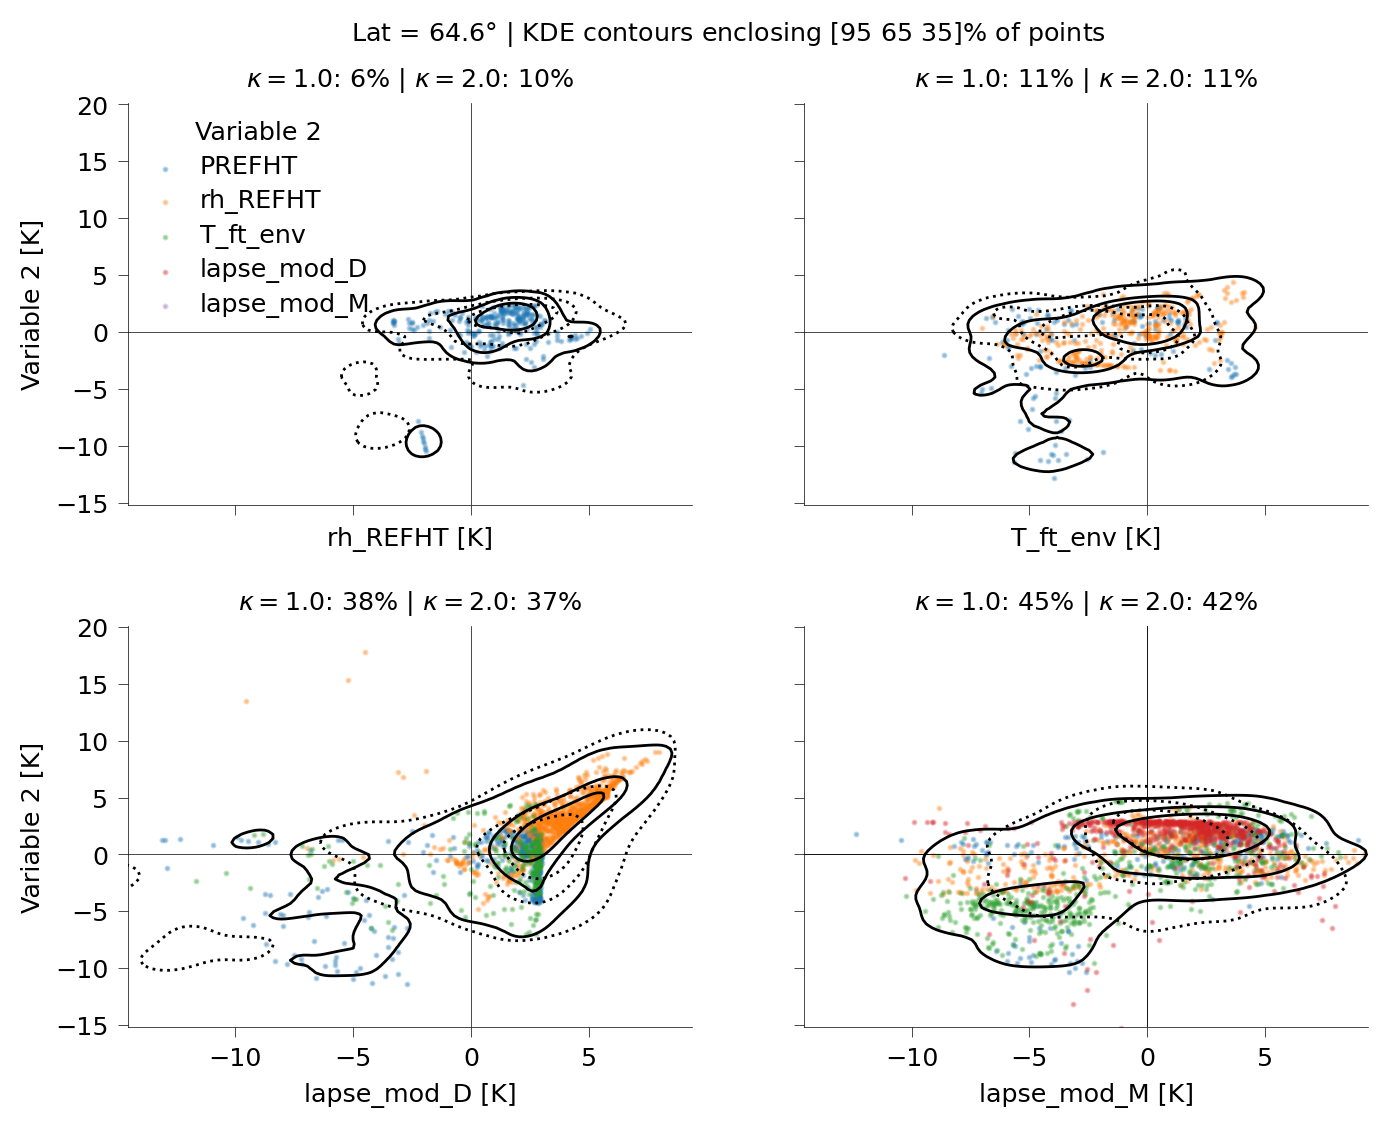

In [265]:
# Define cumulative probabilities for contours
from scipy.ndimage import binary_closing
scatter_co2_ind_show = 0
cum_levels = np.arange(0.35, 1.0, 0.3)[::-1]  # 90%, 80%, ..., 10%

# Grid for evaluation
x_min = ds_use['TREFHT_cont1'].min().item()
x_max = ds_use['TREFHT_cont1'].max().item()
y_min = ds_use['TREFHT_cont2'].min().item()
y_max = ds_use['TREFHT_cont2'].max().item()
X, Y = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
positions = np.vstack([X.ravel(), Y.ravel()])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, 8)
ax = ax.flatten()
for i in range(ds.co2.size):
    for j, key in enumerate(var_recon_list):
        if i==0:
            ax[j-1].set_xlabel(f"{key} [K]")
            ax[j-1].axhline(0, color='k',lw=ax_linewidth)
            ax[j-1].axvline(0, color='k',lw=ax_linewidth)
        x = ds_use['TREFHT_cont1'].where(ds_use['var1_id']==j).isel(co2=i).values.flatten()
        y = ds_use['TREFHT_cont2'].where(ds_use['var1_id']==j).isel(co2=i).values.flatten()
        values = np.vstack([x[np.isfinite(x)], y[np.isfinite(x)]])

        if values.size == 0:
            continue

        # KDE estimate
        kde = gaussian_kde(values, bw_method=0.3)
        Z = kde(positions).reshape(X.shape)

        # Compute contour levels that enclose desired fraction of points
        Z_flat = Z.flatten()
        Z_sorted = np.sort(Z_flat)[::-1]  # sort descending
        cumsum = np.cumsum(Z_sorted)
        cumsum /= cumsum[-1]  # normalize to 1
        # cumsum = cumsum * values.shape[1] / x.shape[0]

        # Map cumulative probability to density thresholds
        levels = [Z_sorted[np.searchsorted(cumsum, lev)] for lev in cum_levels[cum_levels<np.max(cumsum)]]

        # Plot contours
        ax[j-1].contour(X, Y, Z, levels=levels, colors=f"k", linewidths=1, linestyles=[None, ':'][i])
        label_use = f"$\kappa = {ds_sl.co2.values[i]:.1f}$: {np.isfinite(x).sum()/(lsm.sel(lat=ds_sl.lat).sum() * ds_sl.sample.size)*100:.0f}%"
        if i == 0:
            ax[j-1].set_title(f"{label_use}")
        else:
            ax[j-1].set_title(f"{ax[j-1].get_title()} | {label_use}")
        if i == scatter_co2_ind_show:
            for k, key2 in enumerate(var_recon_list):
                use_ind = (ds_use['var1_id']==j) & (ds_use['var2_id']==k)
                if use_ind.sum() == 0:
                    if j==1:
                        ax[j-1].scatter(-100, -100, color=f"C{k}", marker='.', s=5, alpha=0.3, label=key2)
                    continue
                x = ds_use['TREFHT_cont1'].where(use_ind).isel(co2=i).values.flatten()
                y = ds_use['TREFHT_cont2'].where(use_ind).isel(co2=i).values.flatten()
                ax[j-1].scatter(x, y, color=f"C{k}", marker='.', s=5, alpha=0.3, label=key2)

# ax[0].set_xlim(-5, 2.5)
# ax[0].set_ylim(-4, 2.5)
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_ylabel("Variable 2 [K]")
ax[2].set_ylabel("Variable 2 [K]")
ax[0].legend(title="Variable 2")
fig.suptitle(f"Lat = {ds_sl.lat:.1f}$\degree$ | KDE contours enclosing {(np.round(cum_levels*100)).astype(int)}% of points", y=0.95)
update_fontsize(fig, 8)
# ax[0].xlabel("TREFHT_cont1")
ax[0].set_xlim(ax_lim_cont[0])
ax[1].set_ylim(ax_lim_cont[1])
# plt.ylabel("TREFHT_cont2")
# plt.title("KDE contours enclosing 10-90% of points")
fig.subplots_adjust(hspace=0.3)
plt.show()